In [253]:
#!pip install mlxtend

In [254]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder , StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_confusion_matrix
#from sklearn.metrics import confusion_matrix

In [255]:
#loading the normalized dataset from previous work
file_path = "/Users/arinpramanick/Desktop/Datasets/Human Activity Tracking/Mimo_ActivityLogging(Kalman).csv"
data = pd.read_csv(file_path)

In [256]:
data.head()

,timestamp,duration,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,7088,0.186,Sitting,0.279340,0.070008,0.050315,0.234731,0.219081,0.224228
1,7088,0.347,Sitting,0.373055,0.093197,0.067053,0.315348,0.293433,0.303420
2,7088,0.508,Sitting,0.420639,0.105932,0.075955,0.357463,0.331588,0.343627
3,7088,0.668,Sitting,0.448987,0.113612,0.081010,0.382347,0.353774,0.367825
4,7088,0.829,Sitting,0.469208,0.118123,0.083943,0.398232,0.367948,0.383115


In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15428 entries, 0 to 15427
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  15428 non-null  int64  
 1   duration   15428 non-null  float64
 2   activity   15428 non-null  object 
 3   acc_x      15428 non-null  float64
 4   acc_y      15428 non-null  float64
 5   acc_z      15428 non-null  float64
 6   gyro_x     15428 non-null  float64
 7   gyro_y     15428 non-null  float64
 8   gyro_z     15428 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.1+ MB


In [258]:
FS = 10
WINDOW_SIZE = FS*2  #20 sec data 
STRIDE = FS * 2  #overlap
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [259]:
# Check class distribution
print("Class distribution:\n", data['activity'].value_counts())

Class distribution:
 activity
Standing    5561
Sitting     4999
Walking     4868
Name: count, dtype: int64


In [260]:
data = data.drop(['timestamp' , 'duration'] , axis = 1).copy()
data.head()

,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,Sitting,0.279340,0.070008,0.050315,0.234731,0.219081,0.224228
1,Sitting,0.373055,0.093197,0.067053,0.315348,0.293433,0.303420
2,Sitting,0.420639,0.105932,0.075955,0.357463,0.331588,0.343627
3,Sitting,0.448987,0.113612,0.081010,0.382347,0.353774,0.367825
4,Sitting,0.469208,0.118123,0.083943,0.398232,0.367948,0.383115


In [261]:
# # Normalize the data using StandardScaler
# scaler = StandardScaler()
# data[sensor_cols] = scaler.fit_transform(data[sensor_cols])
# data.head()

In [262]:
# # Save the scaler for testing consistency
# joblib.dump(scaler, 'scaler.pkl')

In [263]:
# Create sliding windows
def create_sliding_windows(data, window_size, stride):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        window = data[sensor_cols].iloc[i:i + window_size].values
        X.append(window)
        y.append(data['activity'].values[i + window_size - 1])  # Label at the end of the window
    return np.array(X), np.array(y)

X, y = create_sliding_windows(data, WINDOW_SIZE, STRIDE)

In [264]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Encode windowed labels
y_categorical = to_categorical(y_encoded)  # Convert to one-hot

In [265]:
encoder.classes_

array(['Sitting', 'Standing', 'Walking'], dtype='<U8')

In [266]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (771, 20, 6)
y shape: (771,)


In [267]:
# Reshape for CNN input (samples, window_size, features, channels)
X = X.reshape(-1, WINDOW_SIZE, len(sensor_cols), 1)

In [268]:
X.shape

(771, 20, 6, 1)

In [269]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [270]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

In [271]:
# Data augmentation functions
def jitter(x, sigma=0.03):
    return x + np.random.normal(0, sigma, x.shape)

def scaling(x, sigma=0.1):
    factor = np.random.normal(1, sigma)
    return x * factor

def time_warp(x, stretch_factor=0.2):
    len_x = x.shape[0]
    stretch = np.random.uniform(1 - stretch_factor, 1 + stretch_factor)
    indices = np.round(np.arange(0, len_x, stretch)).astype(int)
    indices = np.clip(indices, 0, len_x - 1)
    warped = x[indices]
    if len(warped) < len_x:
        pad_size = len_x - len(warped)
        warped = np.pad(warped, ((0, pad_size), (0, 0), (0, 0)), mode='edge')
    elif len(warped) > len_x:
        warped = warped[:len_x]
    return warped

def augment_data(X):
    augmented = []
    for sample in X:
        augmented.append(jitter(sample))
        augmented.append(scaling(sample))
        augmented.append(time_warp(sample))
    return np.array(augmented)

In [272]:
X.shape

(771, 20, 6, 1)

In [273]:
# Apply augmentation to training data
X_aug = augment_data(X_train)
X_train_final = np.concatenate((X_train, X_aug), axis=0)
y_train_final = np.concatenate((y_train, np.tile(y_train, (3, 1))), axis=0)

In [274]:
num_classes = 3

In [275]:
#2D CNN model
model = Sequential()

In [276]:
# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(WINDOW_SIZE, len(sensor_cols), 1),
                 padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

/Users/arinpramanick/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [277]:
# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

In [278]:
# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

In [279]:
# Flatten and dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))
# Replace flatten and dense with GlobalAveragePooling2D
#model.add(GlobalAveragePooling2D())

In [280]:
# Output layer
#model.add(Dense(num_classes, activation='softmax'))

In [281]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [282]:
print(f"X_train shape: {X_train.shape}")

X_train shape: (616, 20, 6, 1)


In [283]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [284]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 20, 6, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 20, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 10, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 10, 3, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 10, 3, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 5, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 5, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 5, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,003 (687.51 KB)

 Trainable params: 175,555 (685.76 KB)

 Non-trainable params: 448 (1.75 KB)

In [285]:
# Train the model with class weights
history = model.fit(X_train_final, y_train_final, validation_data=(X_test, y_test),
                    epochs=20, batch_size=32, class_weight=class_weight_dict)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3573 - loss: 2.2021 - val_accuracy: 0.3806 - val_loss: 1.3754
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3891 - loss: 1.4187 - val_accuracy: 0.3806 - val_loss: 1.5937
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3778 - loss: 1.3696 - val_accuracy: 0.3806 - val_loss: 1.7512
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3994 - loss: 1.3520 - val_accuracy: 0.3806 - val_loss: 2.2249
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4003 - loss: 1.3432 - val_accuracy: 0.3806 - val_loss: 1.7025
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4332 - loss: 1.3308 - val_accuracy: 0.3806 - val_loss: 1.3009
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4095 - loss: 1.3268 - val_accuracy: 0.3806 - val_loss: 1.1515
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4427 - loss: 1.2958 - val_accuracy: 0.6000 - val_loss:

In [286]:
# def plot_learningCurve(history , epochs):
#     epoch_range = range(1 , epochs+1)
#     plt.plot(epoch_range , history.history['accuracy'])
#     plt.plot(epoch_range , history.history['val_accuracy'])
#     plt.title('Model Accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend(['Train' , 'Val'], loc = 'upper left')
#     plt.show()
    

#     plt.plot(epoch_range , history.history['loss'])
#     plt.plot(epoch_range , history.history['val_loss'])
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train' , 'Val'], loc = 'upper left')
#     plt.show()

In [287]:
# plot_learningCurve(history, 29)

In [288]:
#Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}'),
print(f'Test Accuracy: {accuracy:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9355 - loss: 0.8924
Test Loss: 0.8949
Test Accuracy: 0.9290


In [289]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
              precision    recall  f1-score   support

     Sitting       0.97      1.00      0.98        59
    Standing       0.86      0.96      0.91        56
     Walking       1.00      0.78      0.87        40

    accuracy                           0.93       155
   macro avg       0.94      0.91      0.92       155
weighted avg       0.94      0.93      0.93       155



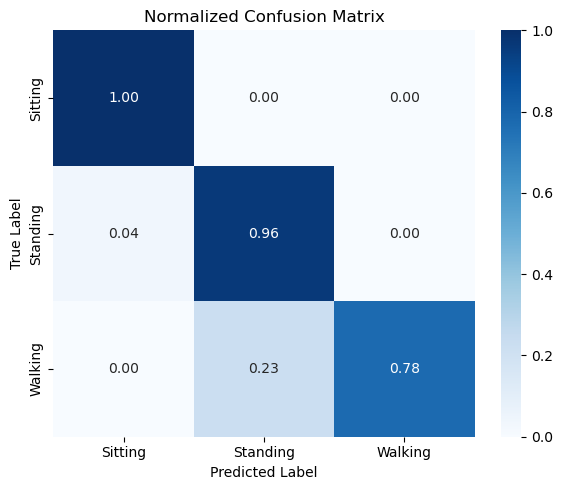

In [290]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_normalized_conf_matrix(y_true, y_pred, labels):
    # Compute normalized confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Plot the normalized confusion matrix
plot_normalized_conf_matrix(y_true, y_pred_classes, labels=encoder.classes_)


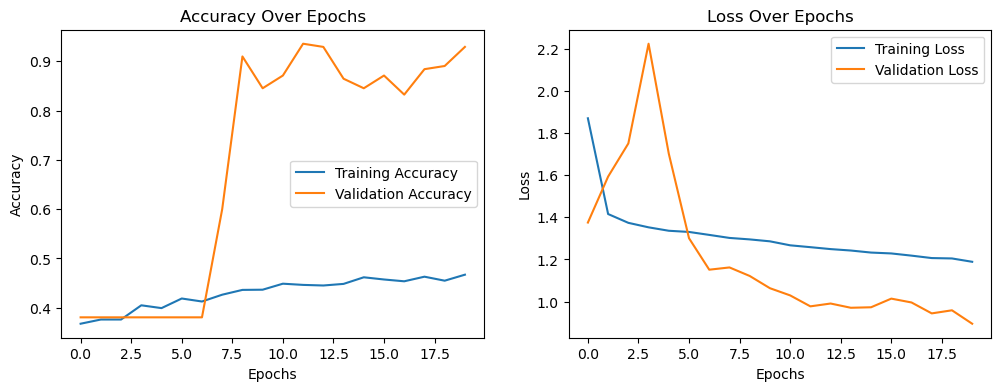

In [291]:
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

In [292]:
#model.save("activity_classification_model.h5")